In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from sys import platform
from point_in_polygon import wn_PnPoly
from pathplanner import *
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [4]:
# d = 1
# lines = np.array([[2,0],[2,10],[15,10],[10,8],[8,8],[5,3],[8,4],[12,0],[2,0]])
# path_list = polygon_path(lines,d,plotting=True)
# wn_PnPoly([10,8], lines)

In [5]:
 # %matplotlib inline
# fig = plt.figure()
# ax = fig.add_subplot(111)
# for path in path_list:
#     ax.plot(path[:,0],path[:,1])
# plt.axis("equal")
# plt.grid()
# plt.show()

In [6]:
from muscle_printing import *

TOOL = { # ratio between extruders
    CONDUCTIVE:[0, 0.5, 0, 0.5],
    MUSCLE:[0.5, 0, 0,  0.5],
    SKIN:[0, 0.5, 0.5,  0]
}
D = 22.63
# d = 1.75 # gauge14
d = .99  # gauge18

gcode_para = { # G code parameters
    'D':D,
    'd':d,
    'applied_percentage':1,
    'TOOL':TOOL,
    'dump_location':[-200, -200, 55],
    'feedrate_move':1000,
    'feedrate_quickmove':1800,
    'feedrate_extrude':(d**2) / (3.2**2),
    'total_volume_change':4000.0, # [mm^3]
    'max_reuse_volume':1500,
    }
###################################################################################################

In [7]:
gcode_para['feedrate_extrude']

0.09571289062499998

In [8]:
# loop to add z dimension to path_list
def add_Z(path_list,z,tool):
    if type(path_list)!=list:
        path_list = [path_list]
    if type(z) == np.ndarray:
        new_path_list = [tool]
        for z_k in z:
            for path in path_list:
                path_with_z =np.hstack([path,np.ones((path.shape[0],1))*z_k])
                new_path_list.append(path_with_z)
    else:
        new_path_list = [tool]
        for path in path_list:
            path_with_z =np.hstack([path,np.ones((path.shape[0],1))*z])
            new_path_list.append(path_with_z)
    return(new_path_list)
# def height_vector(num_layers,layer_height,z_start):
#     cylinder_height = num_layers*layer_height
#     num = num_layers + 1
#     #n = np.linspace(0,10,num)
#     n = np.arange(0,100)
#     k_n = 0.3  # .1 for printing just silicon(worked perfeclty for cylinder)/.2 for printing silicon and ethanol
#     A_final = 0.7 # .8 for printing just silicon
#     d_n = A_final+np.exp(-k_n*n)*(1-A_final)
#     k = np.linspace(z_start,cylinder_height+z_start,num)
#     d_n = d_n[0:len(k)]
#     k = k*d_n
#     #k = z_start-d + d * d_n.cumsum()
#     return(k)
def height_vector(num_layers,layer_height,z_start):
    """
    height_vector return the z height for printing each layer.
    num_layers is the total number of layer
    layer_height is the ideal layer height, usually it is the printer tip diameter
    z_start is the starting Z height
    @jacobjoseph;@boxiXia
    """
    b = 0.33
    a = 0.7 # final layer height
    k = np.arange(0,num_layers)
    z_k = z_start + layer_height*(k*a+(1-a)*(1-np.exp(-b*k))/(1-np.exp(-b)))
    cylinder_height = z_k[-1]-z_k[0]
    print("cylinder_height>={0}".format(cylinder_height))
    return(z_k)

In [9]:
# add_Z(path_list,z = 1,tool = 1)

[  4.65         5.20146443   5.73258634   6.26341824   6.80498465
   7.36261486   7.93815457   8.53141363   9.1410974    9.76539203
  10.40232055  11.04994933  11.70649834  12.37039149  13.04027044
  13.71498763]


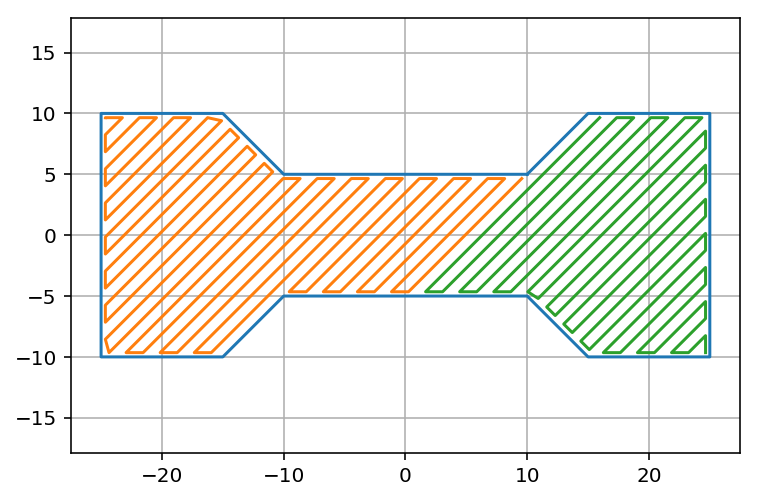

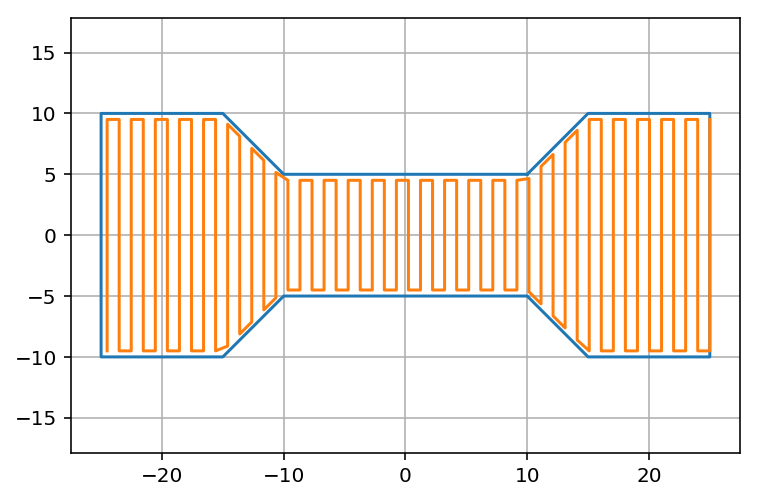

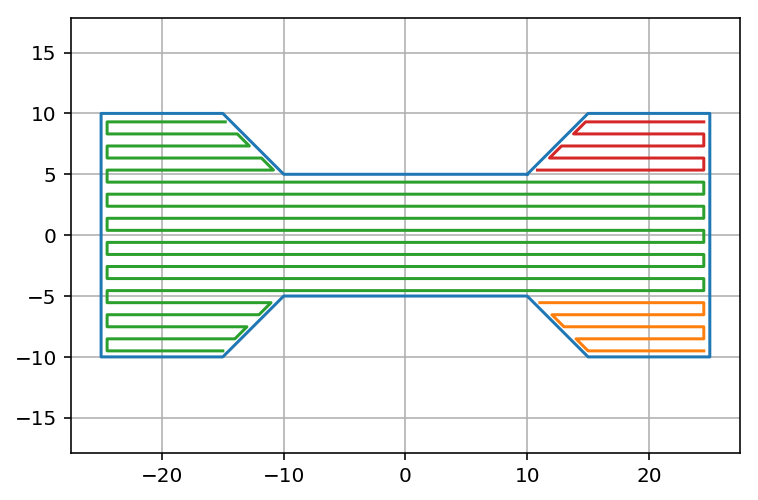

[[ 24.505  -9.505]
 [ 15.     -9.505]
 [ 14.01   -8.515]
 [ 24.505  -8.515]
 [ 24.505  -7.525]
 [ 13.02   -7.525]
 [ 12.03   -6.535]
 [ 24.505  -6.535]
 [ 24.505  -5.545]
 [ 11.04   -5.545]]


In [10]:
skin = 2
muscle  = 1
num_layers = 15
z_start = 4.65
l1=20
l3 = 30
l2=50
h1=10
h2=20

# For ASTM D412-16 Die A
# l1=59
# l3 = 74 # for 45 degree angle from inner to outer rectangle
# #l3 = 84.98 # for 30 degree angle from inner to outer rectangle
# l2=140

# h1=12
# h2=25

# For ASTM D412-16 Die C
#l1=59
#l3 = 74 # for 45 degree angle from inner to outer rectangle
#l3 = 84.98 # for 30 degree angle from inner to outer rectangle
#l2=115

#h1=6
#h2=25

# height of ASTM D412-16 Die A is 3 mm
# d = .99
z = height_vector(num_layers,d,z_start)
print(z)
x = 0 # offset in x-direction
y = 0 # offset in y-direction
dog_bone = np.array(
[[l1/2+x,h1/2+y],[l3/2+x,h2/2+y],[l2/2+x,h2/2+y],[l2/2+x,-h2/2+y],[l3/2+x,-h2/2+y],[l1/2+x,-h1/2+y],[-l1/2+x,-h1/2+y],[-l3/2+x,-h2/2+y],[-l2/2+x,-h2/2+y],[-l2/2+x,h2/2+y],
[-l3/2+x,h2/2+y],[-l1/2+x,h1/2+y],[l1/2+x,h1/2+y]]
)
path_list = polygon_path(dog_bone,d,plotting=True,angle=-np.pi/4)       
lines_list_diag_single = add_Z(path_list,z,skin)
path_list = polygon_path(dog_bone,d,plotting=True,angle=0)
lines_list_vert = add_Z(path_list,z,skin)
path_list = polygon_path(dog_bone,d,plotting=True,angle=np.pi/2)
print(path_list[0])
lines_list_horz = add_Z(path_list,z,skin)
#print(lines_list_horz)

In [87]:
#script to cris-cross the diagonal pattern
def criss_cross(dog_bone,d,num_layers,z,tool):
    path_list_1 = polygon_path(dog_bone,d,plotting=False,angle=-np.pi/4)
    path_list_2 = polygon_path(dog_bone,d,plotting=False,angle=np.pi/4)
    lines_list_diag = [add_Z(path_list_1,z[0],tool)[0]]
    for i in range(num_layers+1):
        if i % 2 == 0:
            path = path_list_1
        else:
            path = path_list_2
        for j in range(1,len(add_Z(path,z[i],tool))):
            lines_list_diag.append(add_Z(path,z[i],tool)[j])
    lines_list_diag = [lines_list_diag]
    return(lines_list_diag)
#print(lines_list_diag)
lines_list_diag = criss_cross(dog_bone,d,num_layers,z,skin)
#lines_list_diag = [[add_Z(path_list_1,z[0])[0],add_Z(path_list_1,z[0])[1],add_Z(path_list_1,z[0])[2],add_Z(path_list_1,z[0])[3],add_Z(path_list_2,z[1])[1]]]
def optimize_horz_path(dog_bone,d,z,tool):
    new_path_list = []
    path_list = polygon_path(dog_bone,d,plotting=False,angle=np.pi/2)
    new_path_list.append(path_list[0])
    new_path_list.append(path_list[2][::-1])
    new_path_list.append(path_list[1][::-1])
    #new_path_list.append(path_list[3][::-1])
    lines_list_horz = add_Z(new_path_list,z,tool)
    return(lines_list_horz)

In [88]:
# # script for 3 types (diag,horz,vert) dog_bones in one print
# lines_list_diag = []
# lines_list_horz = []
# lines_list_vert = []
# lines_list = []
# for j in range(-1,2):
#     for i in range(-2,3):
#         x = (l2+10)*j
#         if j == -1 or j == 1:
#             y = (h2+10)*(i*-1)
#         else:
#             y = (h2+10)*i
#         dog_bone = np.array(
#         [[l1/2+x,h1/2+y],[l3/2+x,h2/2+y],[l2/2+x,h2/2+y],[l2/2+x,-h2/2+y],[l3/2+x,-h2/2+y],[l1/2+x,-h1/2+y],[-l1/2+x,-h1/2+y],[-l3/2+x,-h2/2+y],[-l2/2+x,-h2/2+y],[-l2/2+x,h2/2+y],
#         [-l3/2+x,h2/2+y],[-l1/2+x,h1/2+y],[l1/2+x,h1/2+y]]
#         )
#         if j == -1:            
#             path_list_vert = polygon_path(dog_bone,d,plotting=False,angle=0)
#             lines_list_vert.append(add_Z(path_list_vert,z,skin))
#             lines_list.append(add_Z(path_list_vert,z,skin))
#         if j == 0:
#             lines_list_diag.append(criss_cross(dog_bone,d,num_layers,z,skin))
#             lines_list.append(criss_cross(dog_bone,d,num_layers,z,skin))
#         if j == 1:
#             lines_list_horz.append(optimize_horz_path(dog_bone,d,z,skin))
#             lines_list.append(optimize_horz_path(dog_bone,d,z,skin))
# #print(lines_list)

In [89]:
# # script for 2 types (diag,horz,vert) dog_bones in one print
# lines_list_diag = []
# lines_list_horz = []
# lines_list_vert = []
# lines_list = []
# for j in range(0,3):
#     for i in range(-2,3):
#         #x = (l2+10)*j
#         if j == 0 or j == 2:
#             x = (l2/2 + 10)*-1
#             y = (h2+10)*(i*-1)
#         else:
#             x = l2/2 + 10
#             y = (h2+10)*i
#         dog_bone = np.array(
#         [[l1/2+x,h1/2+y],[l3/2+x,h2/2+y],[l2/2+x,h2/2+y],[l2/2+x,-h2/2+y],[l3/2+x,-h2/2+y],[l1/2+x,-h1/2+y],[-l1/2+x,-h1/2+y],[-l3/2+x,-h2/2+y],[-l2/2+x,-h2/2+y],[-l2/2+x,h2/2+y],
#         [-l3/2+x,h2/2+y],[-l1/2+x,h1/2+y],[l1/2+x,h1/2+y]]
#         )
#         if j == 0:
#             path_list_vert = polygon_path(dog_bone,d,plotting=False,angle=0)
#             lines_list_vert.append(add_Z(path_list_vert,z,skin))
#             lines_list.append(add_Z(path_list_vert,z,skin))
#         if j == 1:
#             lines_list_diag.append(criss_cross(dog_bone,d,num_layers,z,skin))
#             lines_list.append(criss_cross(dog_bone,d,num_layers,z,skin))
#         if j == 2:
#             lines_list_horz.append(optimize_horz_path(dog_bone,d,z,skin))
#             lines_list.append(optimize_horz_path(dog_bone,d,z,skin))
# print(len(lines_list))

In [90]:
# d = 1 # offset
# lines_offset = offset_lines(lines,d,left = True)
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.plot(lines[:,0],lines[:,1])
# ax.plot(lines_offset[:,0],lines_offset[:,1])
# plt.axis('equal')
# plt.show()   

In [91]:
# # # # for Diagonal Pattern
# # # g_code_strings = lines_list_to_gcode_strings(lines_list_diag,gcode_para)  

# # # # for horizontal Pattern
# # # g_code_strings = lines_list_to_gcode_strings(lines_list_horz,gcode_para)        

# # # for vertical Pattern
# # g_code_strings = lines_list_to_gcode_strings(lines_list_vert,gcode_para)        
        
# #for all patterns
# # for i in range(len(lines_list)):
# #     j = len(lines_list)-1-i
# #     if i == 0:
# #         g_code_strings = lines_list_to_gcode_strings(lines_list[j])
# #     else:
# #         g_code_strings.insert(0,lines_list_to_gcode_strings(lines_list[j])[0])

# # dumping:
# g_code_strings.insert(0,'G0 X-200.0000 Y-200.0000 Z15.0000 F1500\nG1 F0.4624\nG1 E0:3.5:3.5:0 F0.4624\nG4 P6000\nG0 F1800')
# # initialization
# init = initilize_parameters(4,is_absolute=True,is_mm=True,feedrate = 1500 )
# g_code_strings.insert(0,init)

# s = ''.join(g_code_strings)
# if platform == 'win32':
#     f = open('D:/Google Drive/3D printing soft muscle/G-Code/dog_bones.g','w')
# else:
#     f = open('/Users/davidjoseph/Google Drive/3D printing soft muscle/G-Code/dog_bones.g','w')
# f.write(s)
# f.close()
# print(s)

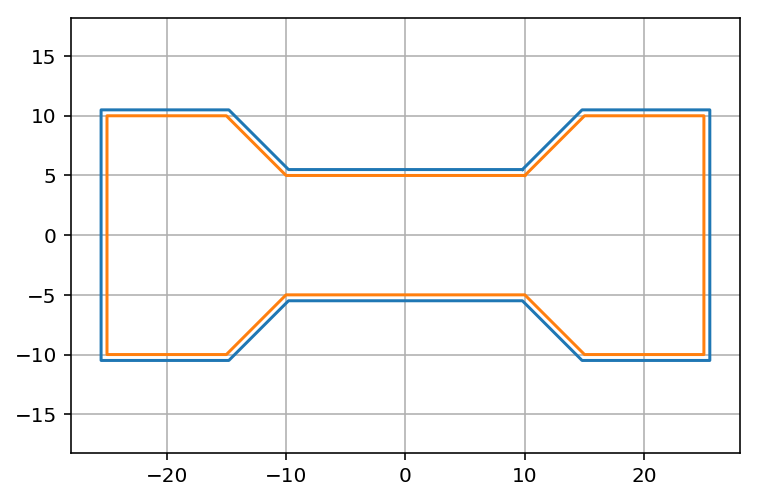

In [92]:
lines = dog_bone
num_offset = 1
offset_list = []
for k in range(num_offset):
    offset_list.append(offset_lines(lines,d*float(k+0.5),left = True))
offset_list = np.vstack(offset_list)

# plot offset walls
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(offset_list[:,0],offset_list[:,1])
ax.plot(dog_bone[:,0],dog_bone[:,1])
plt.axis("equal")
plt.grid()
plt.show()

# Add Z height to offset walls
offset_list = [offset_list]
lines_list_offset = add_Z(offset_list,z,skin)
# print(lines_list_offset)


In [93]:
z

array([  4.65      ,   5.20146443,   5.73258634,   6.26341824,
         6.80498465,   7.36261486,   7.93815457,   8.53141363,
         9.1410974 ,   9.76539203,  10.40232055,  11.04994933,
        11.70649834,  12.37039149,  13.04027044,  13.71498763])

In [94]:
def Optimize_muscle_tool_path(lines_list,z,num_layers):
    z_end = z[num_layers]+2
    for k in range(len(lines_list)):
        if lines_list[k][0] == MUSCLE:
            start_point = lines_list[k][1][0,:]
            start_point[2] = z_end
            lines_list[k][1] = np.vstack([start_point,lines_list[k][1]])
    return(lines_list)

In [105]:
def sinebox():
    l_x = 40
    l_y = 2
    n_wave = 5
    n_points = 50
    x = np.linspace(0,l_x,n_points)
    y = np.sin(np.linspace(0,n_wave*np.pi,n_points))*l_y
    # # plot
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax.plot(x,y)
    # plt.axis("equal")
    # plt.grid()
    # plt.show()
    h = 15
    line = np.empty((int(n_points*2+1),2))
    line[:,0]=np.hstack([x,np.flip(x,0),[0]])
    line[:,1]=np.hstack([y+h/2,-np.flip(y,0)-h/2,[h/2]])
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(line[:,0],line[:,1])
#     plt.axis("equal")
#     plt.grid()
#     plt.show()
    return line

In [106]:
sinebox()

array([[  0.        ,   7.5       ],
       [  0.81632653,   8.13021644],
       [  1.63265306,   8.69622106],
       [  2.44897959,   9.14034451],
       [  3.26530612,   9.41733571],
       [  4.08163265,   9.49897243],
       [  4.89795918,   9.37693684],
       [  5.71428571,   9.06366296],
       [  6.53061224,   8.5910698 ],
       [  7.34693878,   8.00730917],
       [  8.16326531,   7.37185956],
       [  8.97959184,   6.74946599],
       [  9.79591837,   6.20354321],
       [ 10.6122449 ,   5.78971447],
       [ 11.42857143,   5.55014418],
       [ 12.24489796,   5.50924177],
       [ 13.06122449,   5.67117475],
       [ 13.87755102,   6.01944401],
       [ 14.69387755,   6.5185649 ],
       [ 15.51020408,   7.11768274],
       [ 16.32653061,   7.75575432],
       [ 17.14285714,   8.36776748],
       [ 17.95918367,   8.8913651 ],
       [ 18.7755102 ,   9.27319861],
       [ 19.59183673,   9.47436357],
       [ 20.40816327,   9.47436357],
       [ 21.2244898 ,   9.27319861],
 

In [74]:
# script for mulitple sets of walls and muscle in one print TEST
lines_list_vert = []
lines_list_walls = []
x = 0
num_offset = 2
for j in range(0,2):
    for i in range(0,2):
        y = (h2+15)*i
#         dog_bone = np.array(
#         [[-l2/2+x,h2/2+y],[-l3/2+x,h2/2+y],[-l1/2+x,h1/2+y],[l1/2+x,h1/2+y],[l3/2+x,h2/2+y],[l2/2+x,h2/2+y],[l2/2+x,-h2/2+y],[l3/2+x,-h2/2+y],[l1/2+x,-h1/2+y],[-l1/2+x,-h1/2+y],[-l3/2+x,-h2/2+y],[-l2/2+x,-h2/2+y],[-l2/2+x,h2/2+y]
#         ])
#         dog_bone = np.array([[-l2/2+x,h1/2+y],[l2/2+x,h1/2+y],[l2/2+x,-h1/2+y],[-l2/2+x,-h1/2+y],[-l2/2+x,h1/2+y]])
        dog_bone = sinebox()
        dog_bone[:,0]=dog_bone[:,0]+x
        dog_bone[:,1]=dog_bone[:,1]+y
        if j == 0:
            offset_list =np.vstack([offset_lines(dog_bone,d*float(k+0.5),left = True) for k in range(num_offset)])
            #lines_list_offset = add_Z(offset_list,z,skin)
            lines_list_walls.append(add_Z(offset_list,z,skin))
            #print(lines_list_walls)
        else:
#             path_list_vert = polygon_path(offset_lines(dog_bone,d*0.2,left = False),d,plotting=False,angle=0)
            
            dog_bone = sinebox()
            dog_bone[:,0]=dog_bone[:,0]+x
            dog_bone[:,1]=dog_bone[:,1]+y
            path_list_vert = polygon_path(offset_lines(dog_bone,d*0.2,left = False),d,plotting=False,angle=0)
            
            #print(path_list_vert)
            a = np.vstack((path_list_vert[0][0],path_list_vert[0]))
#             lines_list_walls.append(add_Z(a,z,muscle))
            lines_list_walls.append(add_Z(a,np.ones(z.shape)*z[-1]+5,muscle))
            
lines_list_walls = Optimize_muscle_tool_path(lines_list_walls,z,num_layers)



#lines_list_walls = [lines_list_walls]
g_code_strings = lines_list_to_gcode_strings(lines_list_walls,gcode_para)
for gcode in g_code_strings:
    print(gcode)
# dumping:
g_code_strings.insert(0,'G0 X-200.0000 Y-200.0000 Z15.0000 F1500\nG1 F{0:.3f}\nG1 E0:0:0:0\nG1 E0:12:12:0\nG4 P15000\nG0 F1800\n'.format(gcode_para['feedrate_extrude']))
# initialization
init = initilize_parameters(4,is_absolute=True,is_mm=True,feedrate = 1500 )
g_code_strings.insert(0,init)
#print(g_code_strings)
s = ''.join(g_code_strings)
if platform == 'win32':
    f = open('D:/Google Drive/3D printing soft muscle/G-Code/dog_bones_muscle.g','w')
else:
    f = open('/Users/davidjoseph/Google Drive/3D printing soft muscle/G-Code/dog_bones_muscle.g','w')
f.write(s)
f.close()
#print(s)

2
2
1
1
G1 X-0.495000 Y7.743202 Z4.650000 F1500
G1 X0.523866 Y8.529781 Z4.650000 E0.000000:0.001232:0.001232:0.000000 F1000
G1 X1.372591 Y9.118250 Z4.650000 E0.000000:0.000988:0.000988:0.000000 F1000
G1 X2.249717 Y9.595451 Z4.650000 E0.000000:0.000956:0.000956:0.000000 F1000
G1 X3.159792 Y9.904253 Z4.650000 E0.000000:0.000920:0.000920:0.000000 F1000
G1 X4.093783 Y9.997657 Z4.650000 E0.000000:0.000898:0.000898:0.000000 F1000
G1 X5.024728 Y9.858486 Z4.650000 E0.000000:0.000901:0.000901:0.000000 F1000
G1 X5.928303 Y9.511730 Z4.650000 E0.000000:0.000926:0.000926:0.000000 F1000
G1 X6.799200 Y9.007545 Z4.650000 E0.000000:0.000963:0.000963:0.000000 F1000
G1 X7.643056 Y8.404097 Z4.650000 E0.000000:0.000993:0.000993:0.000000 F1000
G1 X8.465363 Y7.763992 Z4.650000 E0.000000:0.000997:0.000997:0.000000 F1000
G1 X9.267515 Y7.152406 Z4.650000 E0.000000:0.000965:0.000965:0.000000 F1000
G1 X10.046318 Y6.631577 Z4.650000 E0.000000:0.000897:0.000897:0.000000 F1000
G1 X10.795391 Y6.251842 Z4.650000 E0.00

In [75]:
z

array([  4.65      ,   5.20146443,   5.73258634,   6.26341824,
         6.80498465,   7.36261486,   7.93815457,   8.53141363,
         9.1410974 ,   9.76539203,  10.40232055,  11.04994933,
        11.70649834,  12.37039149,  13.04027044,  13.71498763])

<IPython.core.display.Javascript object>


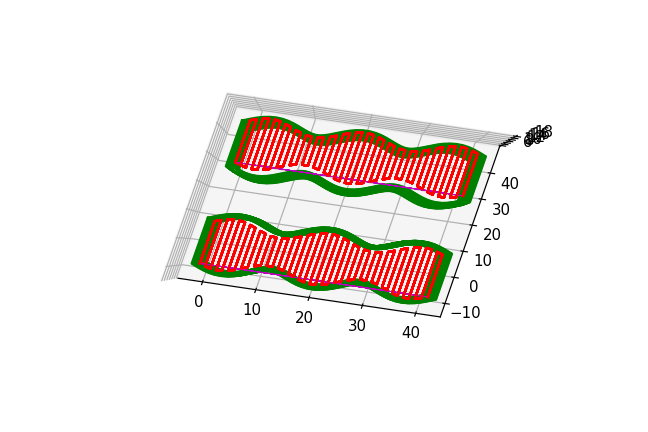

In [76]:
%matplotlib notebook
plot_lines_list(lines_list_walls)

In [57]:
# a = [square(start = (0,0,0),l=100+10*k,d=2,n=1)[0] for k in range(20)]


# lines_list = [[0,a[0],a[1],a[2]],[0,a[3],a[4],a[5]],[1,a[6],a[7],a[8]],[1,a[9],a[10],a[11]]]
# %matplotlib notebook
# plot_lines_list(lines_list)
# g_code_strings = lines_list_to_gcode_strings(lines_list,gcode_para)
# for gcode in g_code_strings:
#     print(gcode)
# # dumping:
# g_code_strings.insert(0,'G0 X-200.0000 Y-200.0000 Z15.0000 F1500\nG1 F0.4624\nG1 E0:3.5:3.5:0 F0.4624\nG4 P6000\nG0 F1800')
# # initialization
# g_code_strings.insert(0,init)
# #print(g_code_strings)
# s = ''.join(g_code_strings)
# if platform == 'win32':
#     f = open('D:/Google Drive/3D printing soft muscle/G-Code/dog_bones_muscle.g','w')
# else:
#     f = open('/Users/davidjoseph/Google Drive/3D printing soft muscle/G-Code/dog_bones_muscle.g','w')
# f.write(s)
# f.close()